In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from datatools.wfip2 import read_dir
from datatools.remote_sensing import ESRL_wind_profiler, Vaisala_CL31

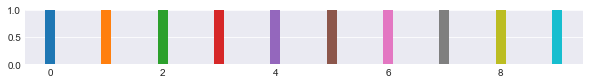

In [4]:
plt.style.use('seaborn-darkgrid')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig,ax = plt.subplots(figsize=(10,1))
for i,color in enumerate(colors):
    ax.axvline(i,color=color,lw=10)

# PBL characterization: 2016-11-21
Using 915 MHz Wind Profilers

In [5]:
tstart = pd.to_datetime('2016-11-21 17:00')
tend = pd.to_datetime('2016-11-22 04:00')

In [6]:
wind_ext = '.winds'
rass_ext = '.temp.txt'

In [7]:
wasco_dpath = '/Users/equon/WFIP2/Wasco/radar.z04.b0/201611'
wasco_prefix = 'radar.z04.b0.2016112'

In [8]:
ceilo_dpath = '/Users/equon/WFIP2/Wasco/ceil.z01.00'
ceilo_prefix = 'ceil.z01.00.2016112'

## Wasco radar

signal-to-noise ratio method, e.g. https://journals.ametsoc.org/doi/full/10.1175/1520-0426(2002)019%3C1745%3ACBLDIM%3E2.0.CO%3B2

In [11]:
%%time
wasco_radar = read_dir(dpath=wasco_dpath,
                       reader=ESRL_wind_profiler,
                       ext='.winds',
                       modes=1,check_na=['SPD','DIR','SNR'],na_values=999999)
#wasco_radar = wasco_radar.sort_values(['date_time','HT'])
wasco_radar = wasco_radar.set_index('date_time')

CPU times: user 8.23 s, sys: 283 ms, total: 8.52 s
Wall time: 10.7 s


In [12]:
wasco_radar.head()

,HT,SPD,DIR,MET_QC,RAD.0,RAD.1,RAD.2,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2,QC.0,QC.1,QC.2
date_time,,,,,,,,,,,,,,,,
2016-11-01 00:00:04,0.081,3.8,304.0,0.0,-0.2,-0.2,1.5,9.0,9.0,9.0,-2.0,0.0,5.0,0.0,0.0,0.0
2016-11-01 00:00:04,0.138,4.0,304.0,0.0,-0.3,-0.2,1.6,9.0,9.0,9.0,-4.0,-1.0,2.0,0.0,0.0,0.0
2016-11-01 00:00:04,0.196,3.9,305.0,0.0,-0.3,-0.2,1.6,9.0,9.0,9.0,-6.0,-4.0,0.0,0.0,0.0,0.0
2016-11-01 00:00:04,0.253,3.3,297.0,0.0,-0.2,0.0,1.3,9.0,9.0,9.0,-15.0,-13.0,-6.0,0.0,0.0,0.0
2016-11-01 00:00:04,0.310,3.2,266.0,0.0,-0.1,0.7,1.1,9.0,9.0,9.0,-18.0,-11.0,-11.0,0.0,0.0,3.7


In [13]:
wasco_radar['HT'] *= 1000.0

In [14]:
wasco_radar['SNR.0'].min(), wasco_radar['SNR.0'].max()

(-27.0, 40.0)

In [15]:
snr0 = wasco_radar.pivot(columns='HT',values='SNR.0')
snr1 = wasco_radar.pivot(columns='HT',values='SNR.1')
snr2 = wasco_radar.pivot(columns='HT',values='SNR.2')

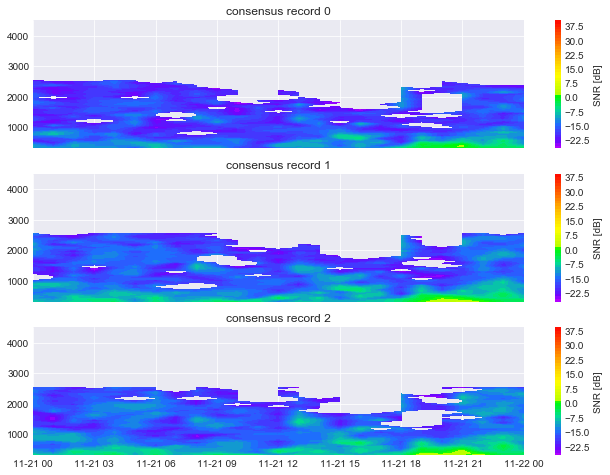

In [16]:
from abl.miscellaneous import idl_colortable
import matplotlib.dates as mdates
levels = 51 #np.arange(30,101,5)

tt,zz = np.meshgrid(snr0.index,snr0.columns,indexing='ij')

fig,ax = plt.subplots(nrows=3, figsize=(11,8), sharex=True, sharey=True)
cont0 = ax[0].contourf(tt,zz,snr0,levels,cmap=idl_colortable())
cont1 = ax[1].contourf(tt,zz,snr1,levels,cmap=idl_colortable())
cont2 = ax[2].contourf(tt,zz,snr2,levels,cmap=idl_colortable())
cbar0 = plt.colorbar(cont0,ax=ax[0])
cbar1 = plt.colorbar(cont1,ax=ax[1])
cbar2 = plt.colorbar(cont2,ax=ax[2])

ax[-1].set_ylim((300,4500))
ax[-1].set_xlim((pd.to_datetime('2016-11-21 00:00:00'),pd.to_datetime('2016-11-22 00:00:00')))
# ax[-1].set_xticks((pd.to_datetime('2016-11-21 00:00:00'),pd.to_datetime('2016-11-22 00:00:00')))
# ax[-1].set_xticks(pd.date_range('2016-11-21 00:00:00','2016-11-22 00:00:00',freq='H'), minor=True)
# ax[-1].xaxis.set_major_locator(mdates.DayLocator())
# ax[-1].xaxis.set_minor_locator(mdates.HourLocator())
# ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d-$b-%y'))
# ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

for i in range(3): ax[i].set_title('consensus record '+str(i))
cbar0.ax.set_ylabel('SNR [dB]')
cbar1.ax.set_ylabel('SNR [dB]')
cbar2.ax.set_ylabel('SNR [dB]')

fig.savefig('SNR_2016-11-21.png',bbox_inches='tight')

(0, 4500)

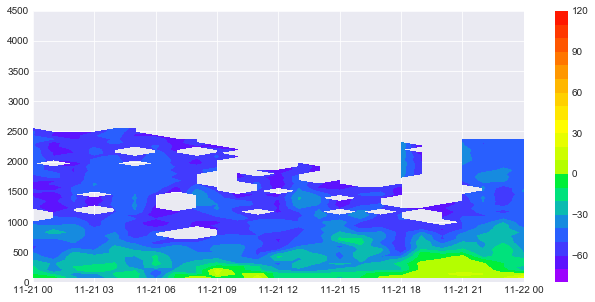

In [17]:
levels = 21 #np.arange(30,101,5)
fig,ax = plt.subplots(figsize=(11,5))
cont = ax.contourf(tt,zz,(snr0+snr1+snr2),levels,cmap=idl_colortable())
cbar = plt.colorbar(cont)
ax.set_xlim((pd.to_datetime('2016-11-21 00:00:00'),pd.to_datetime('2016-11-22 00:00:00')))
ax.set_ylim((0,4500))

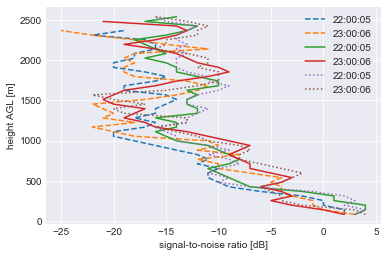

In [18]:
fig,ax = plt.subplots()

selected = (snr0.index >= pd.to_datetime('2016-11-21 21:30:00')) & (snr0.index <= pd.to_datetime('2016-11-21 23:30:00'))
for tstamp, rowdata in snr0.loc[selected].iterrows():
    ax.plot(rowdata.values, snr0.columns, '--', label=tstamp.time())
    
selected = (snr1.index >= pd.to_datetime('2016-11-21 21:30:00')) & (snr1.index <= pd.to_datetime('2016-11-21 23:30:00'))
for tstamp, rowdata in snr1.loc[selected].iterrows():
    ax.plot(rowdata.values, snr1.columns, label=tstamp.time())
    
selected = (snr2.index >= pd.to_datetime('2016-11-21 21:30:00')) & (snr2.index <= pd.to_datetime('2016-11-21 23:30:00'))
for tstamp, rowdata in snr2.loc[selected].iterrows():
    ax.plot(rowdata.values, snr2.columns, ':', label=tstamp.time())
    
ax.set_xlabel('signal-to-noise ratio [dB]')
ax.set_ylabel('height AGL [m]')
ax.legend(loc='best')

## Wasco RASS


In [19]:
%%time
# by default, ESRL_wind_profiler expects a "WINDS" input
# need to set RASS-specific number of returns and the correct columns to QC
wasco_rass = read_dir(dpath=wasco_dpath,
                      reader=ESRL_wind_profiler,
                      ext=rass_ext,
                      modes=1,check_na=['T','Tc','W'])

CPU times: user 4.75 s, sys: 133 ms, total: 4.88 s
Wall time: 6.83 s


In [20]:
wasco_rass.head()

,HT,T,Tc,W,QC_T,QC_Tc,QC_W,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2,date_time
0,0.120,10.8,11.6,-0.5,0.0,0.0,0.0,15.0,15.0,15.0,-9.0,-9.0,-19.0,2016-11-01 00:56:50
1,0.182,10.3,11.2,-0.4,0.0,0.0,0.0,15.0,14.0,15.0,-9.0,-9.0,-20.0,2016-11-01 00:56:50
2,0.245,10.0,10.8,-0.4,0.0,0.0,0.0,15.0,14.0,15.0,-8.0,-8.0,-10.0,2016-11-01 00:56:50
3,0.307,9.6,10.6,-0.6,0.0,0.0,0.0,15.0,15.0,15.0,-9.0,-9.0,-24.0,2016-11-01 00:56:50
4,0.370,9.4,10.5,-0.8,0.0,0.0,0.0,15.0,14.0,15.0,-6.0,-6.0,-26.0,2016-11-01 00:56:50


In [21]:
wasco_rass = wasco_rass.set_index('date_time')

In [22]:
# convert to SI
wasco_rass['HT'] *= 1000.0
wasco_rass['T'] += 273.15
wasco_rass['Tc'] += 273.15

In [23]:
T = wasco_rass.pivot(columns='HT',values='T')   # uncorrected temperatures [deg C]
Tc = wasco_rass.pivot(columns='HT',values='Tc') # corrected consensus temperatures [deg C]
W = wasco_rass.pivot(columns='HT',values='W')   # vertical velocity [m/s]

### Assumed dry adiabatic lapse rate
First-order approximation from Stull, Eqn. 1.5.1d

In [24]:
wasco_rass['theta_approx'] = wasco_rass['Tc'] + 0.0098*wasco_rass['HT']
theta_approx = wasco_rass.pivot(columns='HT',values='theta_approx')

(0, 1000)

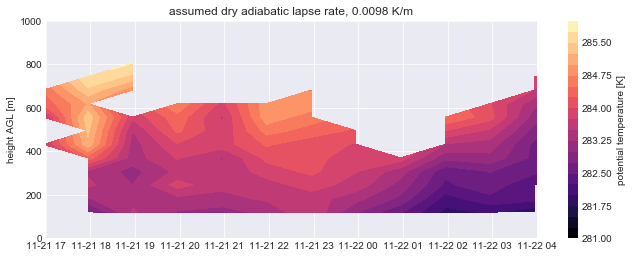

In [25]:
levels = np.arange(281,286.25,0.25)

tt,zz = np.meshgrid(T.index,T.columns,indexing='ij')
fig,ax = plt.subplots(figsize=(11,4))
cont = ax.contourf(tt,zz,theta_approx,levels,cmap='magma')
cbar = plt.colorbar(cont)
cbar.set_label('potential temperature [K]')
ax.set_title('assumed dry adiabatic lapse rate, 0.0098 K/m')
ax.set_ylabel('height AGL [m]')
ax.set_xlim((tstart,tend))
ax.set_ylim((0,1000))

### Hypsometric equation
Z2 - Z1 = Hmean * np.log(p1/p2)

In [26]:
Hmean = 7.5 # km
Z1 = 0.0 # km, height at which T == theta
p0_p = np.exp((wasco_rass['HT']/1000. - Z1)/Hmean)

In [27]:
# Poisson eqn: theta = T * (p0/p)**0.286
wasco_rass['theta_hyp'] = wasco_rass['Tc'] * p0_p**0.286
theta_hyp = wasco_rass.pivot(columns='HT',values='theta_hyp')

(0, 1000)

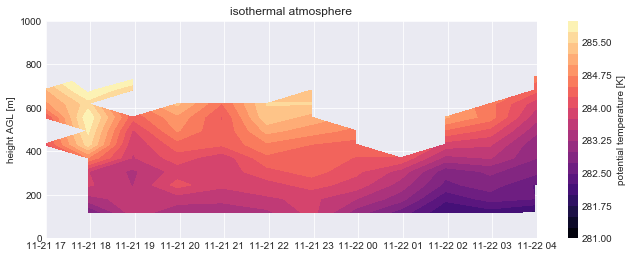

In [28]:
levels = np.arange(281,286.25,0.25)

tt,zz = np.meshgrid(T.index,T.columns,indexing='ij')
fig,ax = plt.subplots(figsize=(11,4))
cont = ax.contourf(tt,zz,theta_hyp,levels,cmap='magma')
cbar = plt.colorbar(cont)
cbar.set_label('potential temperature [K]')
ax.set_title('isothermal atmosphere')
ax.set_ylabel('height AGL [m]')
ax.set_xlim((tstart,tend))
ax.set_ylim((0,1000))

In [51]:
tt.shape, len(T.index), len(T.columns)

((714, 24), 714, 25)

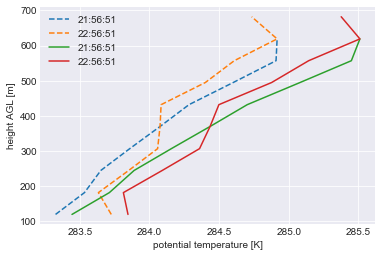

In [29]:
fig,ax = plt.subplots()

selected = (theta_approx.index >= pd.to_datetime('2016-11-21 21:30:00')) & (theta_approx.index <= pd.to_datetime('2016-11-21 23:30:00'))
for tstamp, rowdata in theta_approx.loc[selected].iterrows():
    ax.plot(rowdata.values, theta_approx.columns, '--', label=tstamp.time())
    
selected = (theta_hyp.index >= pd.to_datetime('2016-11-21 21:30:00')) & (theta_hyp.index <= pd.to_datetime('2016-11-21 23:30:00'))
for tstamp, rowdata in theta_hyp.loc[selected].iterrows():
    ax.plot(rowdata.values, theta_hyp.columns, label=tstamp.time())
    
ax.set_xlabel('potential temperature [K]')
ax.set_ylabel('height AGL [m]')
ax.legend(loc='best')

In [30]:
0.5/3600.

0.0001388888888888889

## Check ceilometer

In [34]:
%%time
ceilo = read_dir(dpath=ceilo_dpath,
                 reader=Vaisala_CL31,
                 ext='.xlsx',
                 unpack=False)

Loading /Users/equon/WFIP2/Wasco/ceil.z01.00/ceil.z01.00.20161121.000004.wasco.xlsx...
The unit of the data is [100000*srad*km]^-1
File created: 11/23/2016 1:15:41 AM
Cloud height units: ['Feets' 'Feets' 'Feets']
Backscatter height units: Meters
-File Closed: 11/23/2016 1:19:29 AM
Loading /Users/equon/WFIP2/Wasco/ceil.z01.00/ceil.z01.00.20161122.000002.wasco.xlsx...
The unit of the data is [100000*srad*km]^-1
File created: 11/23/2016 2:03:14 AM
Cloud height units: ['Feets' 'Feets' 'Feets']
Backscatter height units: Meters
-File Closed: 11/23/2016 2:10:16 AM
CPU times: user 1min 8s, sys: 1.15 s, total: 1min 9s
Wall time: 1min 10s


In [35]:
istat = ceilo['Status']
istat.unique() #  0: no error has occurred

array([0, 2, 1, 3, 4])

In [36]:
clouds = ceilo[['Height1','Height2','Height3']]
clouds *= .3048 # convert feet to meters

In [37]:
backscat = ceilo.drop(['Status','Height1','Height2','Height3'], axis=1)

In [38]:
z = np.array(backscat.columns)

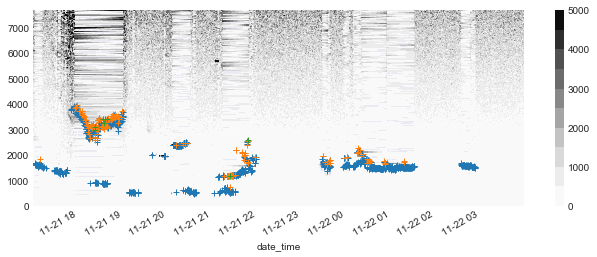

In [39]:
levels = np.arange(0,5001,500)
fig,ax = plt.subplots(figsize=(11,4))
in_trange = (backscat.index >= tstart) & (backscat.index <= tend)

bs = backscat.loc[(istat==0) & in_trange]
tt,zz = np.meshgrid(bs.index, z, indexing='ij')
cont = ax.contourf(tt,zz,bs,levels)
plt.colorbar(cont)

clouds.loc[in_trange,'Height1'].plot(ls='none',marker='+')
clouds.loc[in_trange,'Height2'].plot(ls='none',marker='+')
clouds.loc[in_trange,'Height3'].plot(ls='none',marker='+')

MIXING LAYER HEIGHT ASSESSMENT WITH A COMPACT LIDAR CEILOMETER 
Munkel and Roininen
https://www.vaisala.com/sites/default/files/documents/Mixing_layer_height_assessment_with_a_compact_lidar_ceilometer.pdf

mixed-layer depth ~ largest local gradient of backscatter (i.e., largest decrease in local aerosol concentration)

In [40]:
backscat_10min = backscat.resample('10min').mean()
clouds_10min = clouds.resample('10min').mean()

2016-11-21 22:10:00
2016-11-21 22:20:00
2016-11-21 22:30:00
2016-11-21 22:40:00
2016-11-21 22:50:00
2016-11-21 23:00:00


(0, 2000)

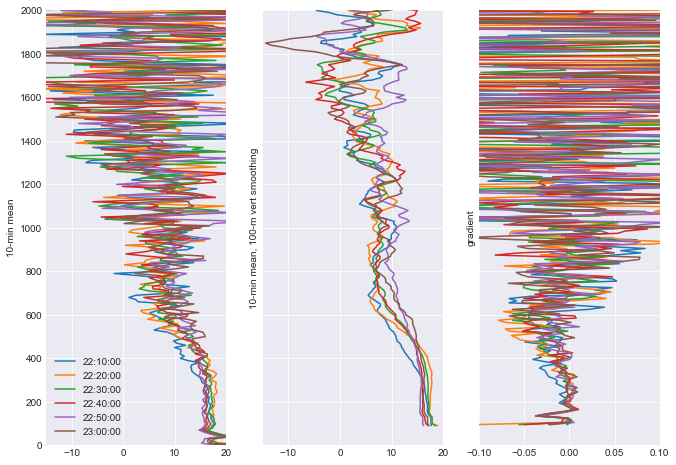

In [41]:
fig,ax = plt.subplots(ncols=3,figsize=(11,8),sharey=True)
zmid = z[:-1] + np.diff(z)/2
in_trange = (backscat_10min.index > pd.to_datetime('2016-11-21 22:00:00')) & (backscat_10min.index <= pd.to_datetime('2016-11-21 23:00:00'))
for tstamp, rowdata in backscat_10min.loc[in_trange].iterrows():
    print(tstamp)
    bs_mean = rowdata.rolling(10).mean()
    scatgrad = np.diff(bs_mean.values) / np.diff(z)
    #ax.plot(rowdata.values, z, label=str(tstamp.time()))
    ax[0].plot(rowdata.values, z, label=str(tstamp.time()))
    ax[1].plot(bs_mean, z)
    ax[2].plot(scatgrad, zmid)
ax[0].set_ylabel('10-min mean')
ax[1].set_ylabel('10-min mean, 100-m vert smoothing')
ax[2].set_ylabel('gradient')
ax[0].legend(loc='best')
ax[0].set_yticks(np.arange(0,2001,200))
ax[0].set_xlim((-15,20))
ax[1].set_xlim((-15,20))
ax[2].set_xlim((-0.1,0.1))
ax[0].set_ylim((0,2000))